<a href="https://colab.research.google.com/github/foxtrotmike/RL-MagLev/blob/master/Maglev_diffprog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A differentiable programming approach to (basic) magnetic levitation
## By Fayyaz Minhas

Consider a metallic ball of mass $m$ at positiopn $x_i = x(t)$ moving with velocity $v_i = v(t)$ at time $t$ which is acted upon by gravity in the downwards direction and a fixed force $F$ in the upward direction resulting from a controllable electromagnet which is used to control the position of the ball along the vertical. The output of the magnet at a given time is modeled as $A_i = A(t)\in[0,1]$. Thus, a net force $A(t)F-mg$ causes acceleration $a_{i} = a(t)=(A(t)F-mg)/m$ in the mass which, in a small time step $\delta = 0.05$, changes the velocity and position of the ball to $v_{i+1}=v(t+\delta) = v(t)+a(t)\delta$ and $x_{i+1}=x(t+\delta) = x(t)+v(t)\delta+0.5a(t)\delta^2$. Thus far we have modeled the physics of the problem. The state of the system can be described by a vector $(v(t),x(t))$ which is dependent upon the previous state and the action taken then. We want to control the system by controlling the electromagnetic output so that the mass reaches a desired vertical target position ($x^*\in[0,10]$). We achieve this through differentiable programming in which we simulate the system together with a controller function $f$ with trainable parameters $\theta$ that produces $A(t)=f(x(t),v(t);\theta)$. The differentiable programming implementation minimizes the error between the current and target position over a number of steps and across multiple episodes with different targets and starting states. This is done by minimizing the following error function for a given episode$\min_{\theta} \sum_{j=1}^{T}j\times |x_{j}-x^*$| over $T$ time steps. Note that this error function emphasizes errors at later timesteps within an episode to penalize steady state errors. 


0 tensor(7.0390, grad_fn=<AbsBackward>) tensor(5.2741, grad_fn=<MulBackward0>)
10 tensor(5.6867, grad_fn=<AbsBackward>) tensor(40.3292, grad_fn=<MulBackward0>)
20 tensor(2.1433, grad_fn=<AbsBackward>) tensor(32.6035, grad_fn=<MulBackward0>)
30 tensor(2.0979, grad_fn=<AbsBackward>) tensor(75.0312, grad_fn=<MulBackward0>)
40 tensor(9.1673, grad_fn=<AbsBackward>) tensor(249.7999, grad_fn=<MulBackward0>)
50 tensor(0.6497, grad_fn=<AbsBackward>) tensor(15.0009, grad_fn=<MulBackward0>)
60 tensor(2.0723, grad_fn=<AbsBackward>) tensor(174.7676, grad_fn=<MulBackward0>)
70 tensor(0.9845, grad_fn=<AbsBackward>) tensor(59.7556, grad_fn=<MulBackward0>)
80 tensor(0.5393, grad_fn=<AbsBackward>) tensor(30.9313, grad_fn=<MulBackward0>)
90 tensor(0.1683, grad_fn=<AbsBackward>) tensor(20.0486, grad_fn=<MulBackward0>)
100 tensor(0.1060, grad_fn=<AbsBackward>) tensor(24.0786, grad_fn=<MulBackward0>)
110 tensor(0.1113, grad_fn=<AbsBackward>) tensor(52.6990, grad_fn=<MulBackward0>)
120 tensor(0.1546, grad_fn

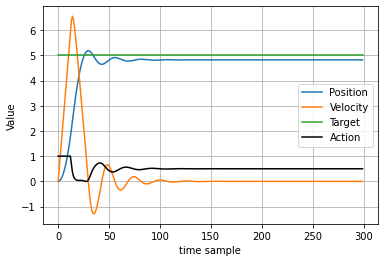

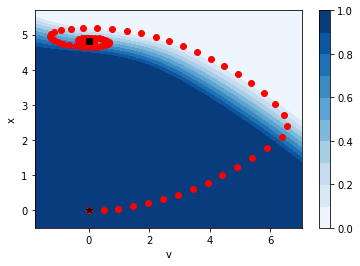

In [3]:

import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
FloatTensor = torch.FloatTensor
from tqdm.notebook import tqdm

def step(state,action):
    """
    Simulate the environment (in a differentiable manner)

    Parameters
    ----------
    state : TYPE
        state = position,veolocity,target.
    action : TYPE
        Action to perform.

    Returns
    -------
    obs : TYPE
        New observation state.

    """
    
    m = 1.0
    g = 9.8
    F = 2*g 
    dt = 0.05 #sampling time
 
    state = state#+0.1*(2*torch.rand(state.shape)-1)
    x0,v0,tt = state[0],state[1],state[2:]
    
    
    a = ( ( action*F/m ) - g )
     
    dv = ( a * dt )
    v = v0 + dv
    dx = ( v0 * dt ) + 0.5 * (a * dt**2) 
    x = x0 + dx
    x = torch.clamp(x,0,10)
    obs = torch.cat((x, v,tt), 0)
    return obs

class Network(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(3, 24)
        self.l3 = nn.Linear(24, 1)
        

    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = self.l3(x)
        x = x
        x = torch.clamp(x,0,1.0) #rises by own power, drops by gravity
        return x
    

model = Network()
optimizer_tloss = optim.Adam(model.parameters(), 1e-2)

model.train()
for e in tqdm(range(200)):
    x0 = random.randint(0,10)
    v0 = (2*np.random.rand()-1)*10
    target = np.random.rand()*10
    state = FloatTensor(np.asarray((x0,v0,target)))
    tloss = 0    
    for t in range(150): #single episode consists of steps with fixed tgt
        action = model(state)
        state = step(state,action)        
        loss = torch.abs(state[0]-target)#+action**2#+state[1]**2 
        tloss+=loss#((t+1)/150)*

    tloss=(((e+1)/200))*tloss       #penalize errors in later episodes more - the model should have learned!

    optimizer_tloss.zero_grad()
    tloss.backward(retain_graph = True)
    optimizer_tloss.step()
    if e%10 == 0: print(e,loss,tloss)
    
    
#%% Evaluation
model.eval()
state = FloatTensor(np.asarray((0,0,0)))
S = []
A = []
for t in range(300):    
    S.append(state.detach().numpy())

    if t%75==0: # change target every 75 iters
        target = 5#np.random.rand()*8+1
        state[-1] = target        

    action = model(state)#FloatTensor(np.asarray([0.55]));#
    a = action
    #a = action.detach().numpy()
    A.append(a)
    state = step(state,action)
S = np.array(S)
A = np.array(A)
plt.plot(S);plt.plot(A,'k');
plt.grid();plt.xlabel('time sample');plt.ylabel('Value');plt.legend(['Position','Velocity','Target','Action'])

#%% policy and state space plot
x = np.linspace(np.min(S[:,0])-0.5, np.max(S[:,0])+0.5, 50)
v = np.linspace(np.min(S[:,1])-0.5, np.max(S[:,1])+0.5, 50)

A = np.zeros((len(x),len(v)))
for i,xi in enumerate(x):
    for j,vj in enumerate(v):
        A[i,j] = model(FloatTensor([xi,vj,target])).data.numpy()[0]
plt.figure()
contours = plt.contourf(v,x,A,levels=np.linspace(0,1,11),cmap='Blues');plt.colorbar()
plt.xlabel("v"); plt.ylabel("x")
plt.scatter(S[:,1],S[:,0],c='r'); plt.plot(S[0,1],S[0,0],c = 'k', marker ='*'); plt.scatter(S[-1,1],S[-1,0],c = 'k', marker ='s')

The computational graph of this model can be visualized (for small $T$) by the following code to reveal that the final output depends on the parameters of the model at all time steps. 

In [ ]:
!pip install torchviz
from torchviz import make_dot
make_dot(tloss,params=dict(model.named_parameters()))

     |████████████████████████████████| 51kB 2.0MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=b8bd5c315d033d58685efaff0dbccac75eda654f9a2b0aaad1b99e273bb4f5e5
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz
